# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band9.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.972265 -0.421903 -0.820829 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.972265 -0.421903 -0.820829 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.972265 -0.421903 -0.820829 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.972265 -0.421903 -0.820829 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.972265 -0.421903 -0.820829 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.983629  ...  -1.0 -0.818716 -0.852568  -1.0  -1.0 -0.936453   
      201547 -0.983629  ...  -1.0 -0.818716 -0.852568  -1.0  -1.0 -0.936453   
      201548 -0.983629  ...  -1.0 -0.818716 -0.852568  -1.0  -1.0 -0.936453   
      201549 -0.983629  ...  -1.0 -0.818716 -0.852568  -1.0  -1.0 -0.936453   
      201550 -0.983629  ...  -1.0 -0.818716 -0.852568  -1.0  -1.0 -0.936453   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.946458  -1.0 -0.861740  
      201547  -1.0 -0.946458  -1.0 -0.854589  
      201548  -1.0 -0.946458  -1.0 -0.856973  
      201549  -1.0 -0.946458  -1.0 -0.856973  
      201550  -1.0 -0.946458  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4    5        6  \
5360 201546 -1.0 -1.000000 -0.972265 -0.421903 -0.820829 -1.0 -1.00000   
     201547 -1.0 -0.999938 -0.642095 -1.000000 -0.966912 -1.0 -1.00000   
     201548 -1.0 -1.000000 -0.972265 -0.421903 -0.820829 -1.0 -1.00000   
     201549 -1.0 -1.000000 -0.641443 -0.912431 -1.000000 -1.0 -0.91877   
     201550 -1.0 -1.000000 -0.972265 -0.421903 -0.820829 -1.0 -1.00000   

                    7    8         9  ...  2039      2040      2041  2042  \
5360 201546 -1.000000 -1.0 -0.983629  ...  -1.0 -0.818716 -0.852568  -1.0   
     201547 -1.000000 -1.0 -0.998226  ...  -1.0 -1.000000 -1.000000  -1.0   
     201548 -1.000000 -1.0 -0.983629  ...  -1.0 -0.818716 -0.852568  -1.0   
     201549 -0.802683 -1.0 -0.960863  ...  -1.0 -1.000000 -1.000000  -1.0   
     201550 -1.000000 -1.0 -0.983629  ...  -1.0 -0.818716 -0.852568  -1.0   

                 2043      2044  2045      2046      2047    Labels  
5360 201546 -1.000000 -0.936453  -1.0 -0.946458 -1.000000 -0.990465  
     201547 -0.948463 -1.000000  -1.0 -0.646902 -0.926385 -0.969011  
     201548 -1.000000 -0.936453  -1.0 -0.946458 -1.000000 -0.995232  
     201549 -1.000000 -0.302077  -1.0 -0.842042 -1.000000 -0.997616  
     201550 -1.000000 -0.936453  -1.0 -0.946458 -1.000000 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

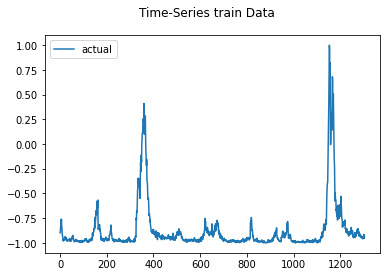

2023-03-06 15:16:23.614563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 15:16:23.614614: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 15:16:23.614647: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 15:16:23.614986: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 15:16:23.875214: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 51.946
Test RMSE: 63.434
Test sMAPE: 133.617
Test R Squared: -2.704
{'mae': 51.9459016873427, 'rmse': 63.43440682761244, 'smape': 133.61733434385934, 'r2': -2.703703248965431}


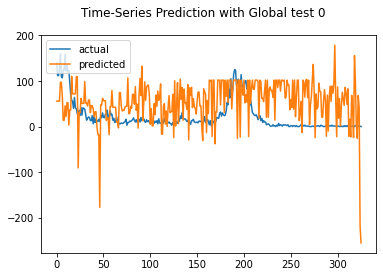

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 45.371
Test RMSE: 62.064
Test sMAPE: 151.020
Test R Squared: -2.545
{'mae': 45.37085679411157, 'rmse': 62.06354296059888, 'smape': 151.02043482407188, 'r2': -2.5453535009132686}


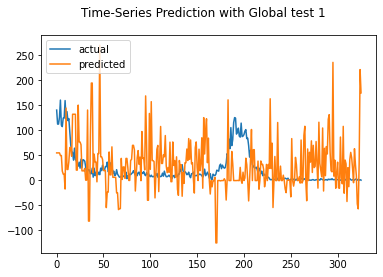

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 44.785
Test RMSE: 56.180
Test sMAPE: 127.935
Test R Squared: -1.905
{'mae': 44.78518597041171, 'rmse': 56.179519240863186, 'smape': 127.9353903821851, 'r2': -1.9049753594977132}


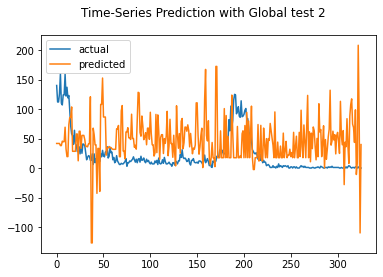

Test MAE: 57.832
Test RMSE: 77.073
Test sMAPE: 134.739
Test R Squared: -4.468
{'mae': 57.832174293925426, 'rmse': 77.07282208122587, 'smape': 134.73905820984777, 'r2': -4.467501852115145}


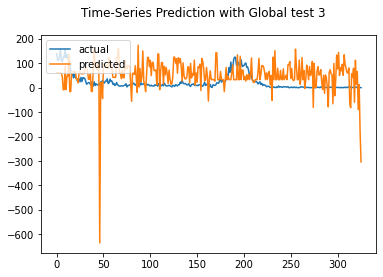

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 49.909
Test RMSE: 56.479
Test sMAPE: 132.026
Test R Squared: -1.936
{'mae': 49.90942767061339, 'rmse': 56.47938821295318, 'smape': 132.0260618059234, 'r2': -1.936069852669775}


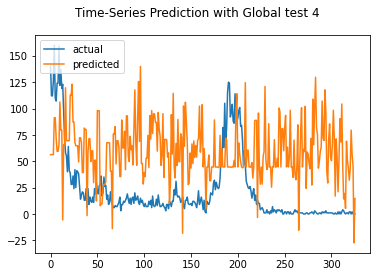

Test MAE: 77.107
Test RMSE: 92.726
Test sMAPE: 139.908
Test R Squared: -6.914
{'mae': 77.10711333557872, 'rmse': 92.72610136963655, 'smape': 139.9081186811032, 'r2': -6.913897428147617}


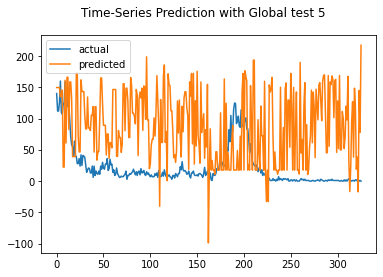

Test MAE: 59.269
Test RMSE: 70.631
Test sMAPE: 144.123
Test R Squared: -3.592
{'mae': 59.26859031791336, 'rmse': 70.63148677736237, 'smape': 144.12296928953361, 'r2': -3.591801573293587}


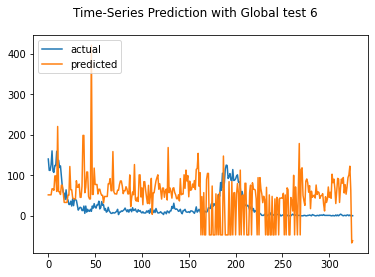

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 48.095
Test RMSE: 56.526
Test sMAPE: 128.725
Test R Squared: -1.941
{'mae': 48.09494332009298, 'rmse': 56.525962379838525, 'smape': 128.72517645814895, 'r2': -1.940914146955873}


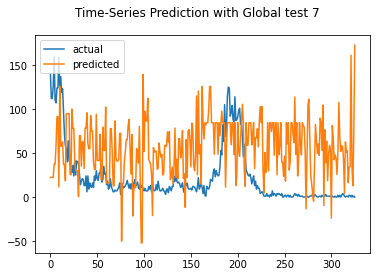

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 57.363
Test RMSE: 71.581
Test sMAPE: 135.170
Test R Squared: -3.716
{'mae': 57.3630841111113, 'rmse': 71.58057384505437, 'smape': 135.17019670677212, 'r2': -3.7160322643963033}


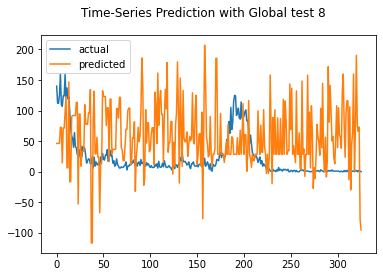

Test MAE: 72.579
Test RMSE: 101.265
Test sMAPE: 133.724
Test R Squared: -8.438
{'mae': 72.57871677932198, 'rmse': 101.26460715802615, 'smape': 133.72360015043873, 'r2': -8.438473933119836}


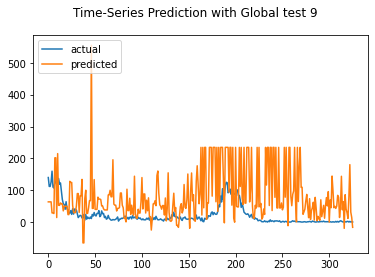

Test MAE: 78.033
Test RMSE: 106.213
Test sMAPE: 143.730
Test R Squared: -9.383
{'mae': 78.03292781078011, 'rmse': 106.21256022931135, 'smape': 143.73040727638727, 'r2': -9.38336620771722}


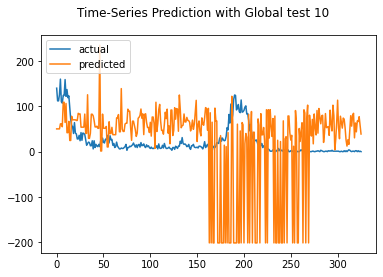

Test MAE: 136.633
Test RMSE: 165.018
Test sMAPE: 176.703
Test R Squared: -24.064
{'mae': 136.63335949950422, 'rmse': 165.01771169579735, 'smape': 176.702902547242, 'r2': -24.06383582372734}


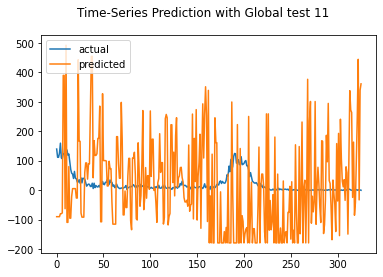

Test MAE: 67.969
Test RMSE: 95.669
Test sMAPE: 144.169
Test R Squared: -7.424
{'mae': 67.96937798210449, 'rmse': 95.66912717251341, 'smape': 144.16875271443436, 'r2': -7.424226589117298}


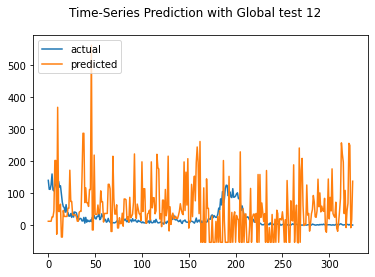

Test MAE: 72.331
Test RMSE: 95.418
Test sMAPE: 146.853
Test R Squared: -7.380
{'mae': 72.33108382210409, 'rmse': 95.41794284492373, 'smape': 146.8529160083256, 'r2': -7.3800481613463855}


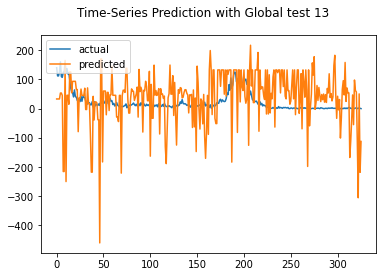

Test MAE: 75.954
Test RMSE: 96.433
Test sMAPE: 137.671
Test R Squared: -7.559
{'mae': 75.95384355081372, 'rmse': 96.4330794076478, 'smape': 137.6706686102712, 'r2': -7.559304699146969}


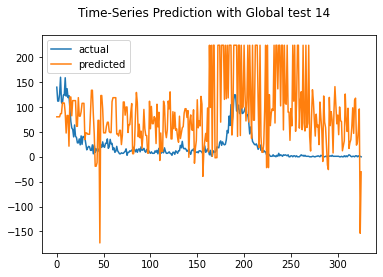

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 43.408
Test RMSE: 54.124
Test sMAPE: 160.777
Test R Squared: -1.696
{'mae': 43.408369489791205, 'rmse': 54.12410732636431, 'smape': 160.7771505008215, 'r2': -1.696298122738996}


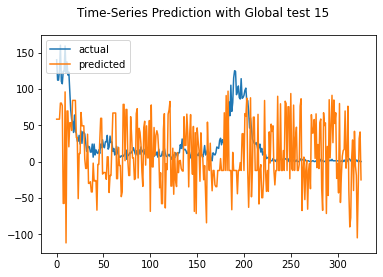

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 56.041
Test RMSE: 72.682
Test sMAPE: 142.638
Test R Squared: -3.862
{'mae': 56.04145575310189, 'rmse': 72.68158192495733, 'smape': 142.63767492607764, 'r2': -3.8622261940830276}


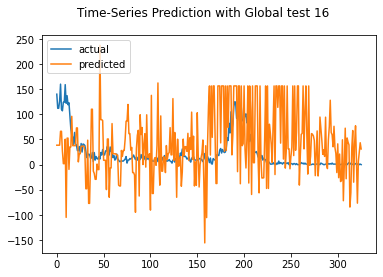

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 44.846
Test RMSE: 52.172
Test sMAPE: 131.332
Test R Squared: -1.505
{'mae': 44.8457402385817, 'rmse': 52.172297050696514, 'smape': 131.33247551760942, 'r2': -1.5053380416271809}


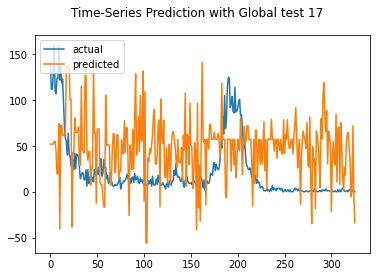

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 52.548
Test RMSE: 62.746
Test sMAPE: 139.994
Test R Squared: -2.624
{'mae': 52.54770877344842, 'rmse': 62.74578518405468, 'smape': 139.99407281865558, 'r2': -2.6237275086863483}


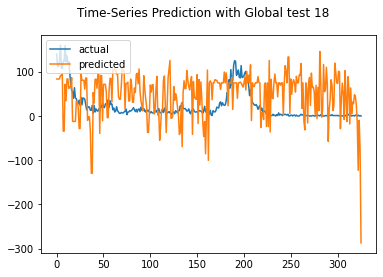

Test MAE: 64.896
Test RMSE: 81.122
Test sMAPE: 146.148
Test R Squared: -5.057
{'mae': 64.89561077312457, 'rmse': 81.12213212664733, 'smape': 146.14817739297635, 'r2': -5.0571053810042}


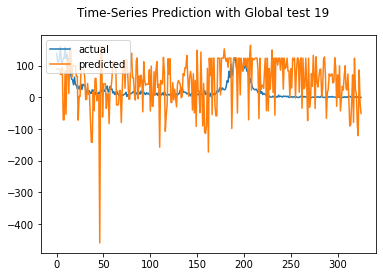

Test MAE: 82.094
Test RMSE: 103.978
Test sMAPE: 151.094
Test R Squared: -8.951
{'mae': 82.09385645316422, 'rmse': 103.97798324185615, 'smape': 151.0943012341095, 'r2': -8.951056576339804}


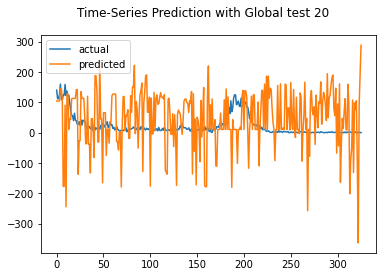

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 46.654
Test RMSE: 63.160
Test sMAPE: 129.630
Test R Squared: -2.672
{'mae': 46.654026709451266, 'rmse': 63.15990602648113, 'smape': 129.629500369732, 'r2': -2.6717184055976078}


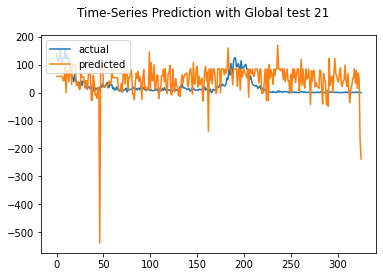

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 52.696
Test RMSE: 69.614
Test sMAPE: 148.884
Test R Squared: -3.461
{'mae': 52.696136719061556, 'rmse': 69.61433965835256, 'smape': 148.88372820869, 'r2': -3.460502961148004}


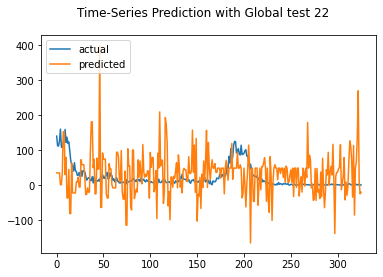

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 49.923
Test RMSE: 63.611
Test sMAPE: 150.163
Test R Squared: -2.724
{'mae': 49.92294164029367, 'rmse': 63.61104582371741, 'smape': 150.16327839400464, 'r2': -2.724358578541477}


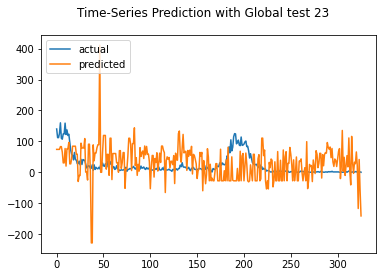

Test MAE: 41.066
Test RMSE: 50.223
Test sMAPE: 129.908
Test R Squared: -1.322
{'mae': 41.06607016573654, 'rmse': 50.223295085327024, 'smape': 129.9079376759992, 'r2': -1.3216503928945724}


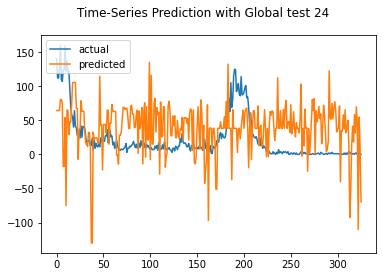

Test MAE: 121.212
Test RMSE: 140.858
Test sMAPE: 167.864
Test R Squared: -17.262
{'mae': 121.21211913365163, 'rmse': 140.857908995827, 'smape': 167.86355398866655, 'r2': -17.26202321015732}


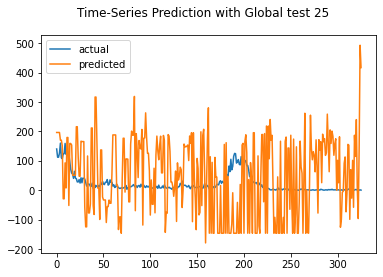

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 73.447
Test RMSE: 96.979
Test sMAPE: 139.802
Test R Squared: -7.657
{'mae': 73.44698473482045, 'rmse': 96.97928910893272, 'smape': 139.8020411673732, 'r2': -7.656541367246424}


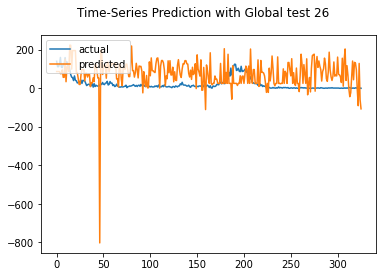

Test MAE: 73.510
Test RMSE: 109.511
Test sMAPE: 142.856
Test R Squared: -10.038
{'mae': 73.50971398699137, 'rmse': 109.51116344597618, 'smape': 142.85641884237555, 'r2': -10.038325642411527}


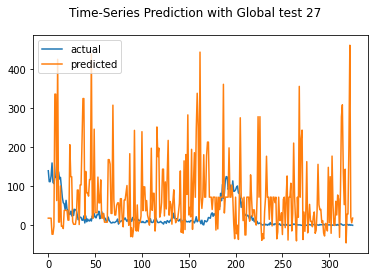

Test MAE: 82.453
Test RMSE: 92.503
Test sMAPE: 152.089
Test R Squared: -6.876
{'mae': 82.45344321713125, 'rmse': 92.50345480041058, 'smape': 152.08907470024764, 'r2': -6.875938607585932}


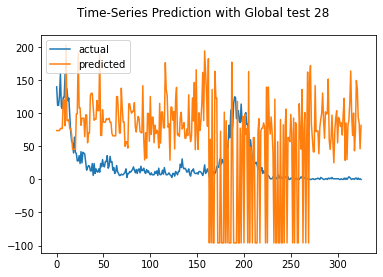

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 43.914
Test RMSE: 55.842
Test sMAPE: 137.114
Test R Squared: -1.870
{'mae': 43.91383154169182, 'rmse': 55.8416760196009, 'smape': 137.11360154766487, 'r2': -1.870141481389366}


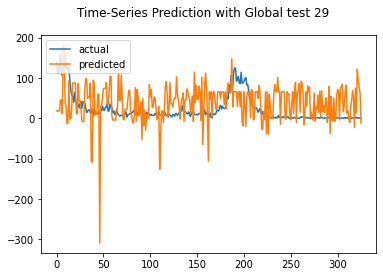

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 48.215
Test RMSE: 61.008
Test sMAPE: 134.456
Test R Squared: -2.426
{'mae': 48.2147286703433, 'rmse': 61.008124769502935, 'smape': 134.45588595477076, 'r2': -2.425798133818448}


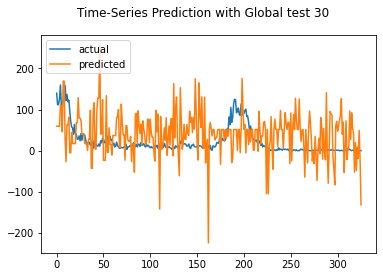

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 39.218
Test RMSE: 48.787
Test sMAPE: 129.408
Test R Squared: -1.191
{'mae': 39.218393945438, 'rmse': 48.78747385818779, 'smape': 129.40831709919217, 'r2': -1.190801751042803}


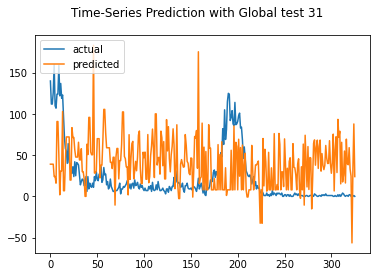

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 55.407
Test RMSE: 65.211
Test sMAPE: 134.978
Test R Squared: -2.914
{'mae': 55.40691422611658, 'rmse': 65.21130352313791, 'smape': 134.97822033791226, 'r2': -2.9141023623113167}


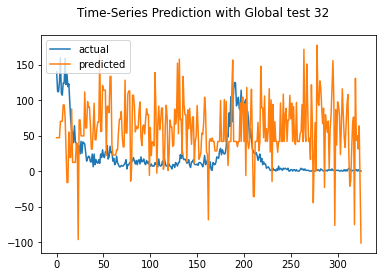

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 46.149
Test RMSE: 55.955
Test sMAPE: 129.433
Test R Squared: -1.882
{'mae': 46.14940199676467, 'rmse': 55.955075144715195, 'smape': 129.43299222899063, 'r2': -1.8818102573956001}


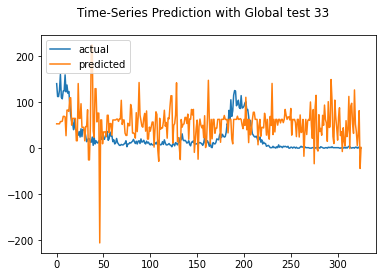

Test MAE: 73.266
Test RMSE: 104.070
Test sMAPE: 162.764
Test R Squared: -8.969
{'mae': 73.26577202637503, 'rmse': 104.07012841325712, 'smape': 162.76437643588233, 'r2': -8.968701621601245}


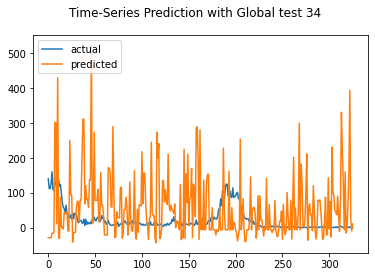

Test MAE: 63.734
Test RMSE: 80.718
Test sMAPE: 133.583
Test R Squared: -4.997
{'mae': 63.73361018757147, 'rmse': 80.71803284155372, 'smape': 133.5827101166314, 'r2': -4.996910326672373}


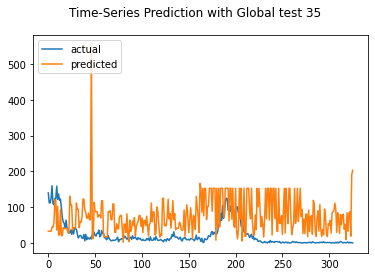

Test MAE: 75.030
Test RMSE: 94.207
Test sMAPE: 142.692
Test R Squared: -7.169
{'mae': 75.02952494028887, 'rmse': 94.207138843289, 'smape': 142.69238298036072, 'r2': -7.168720647075315}


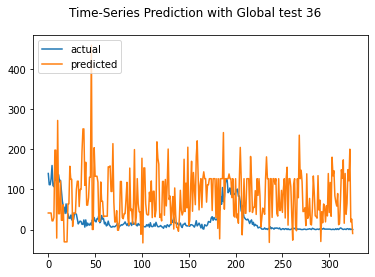

Test MAE: 69.121
Test RMSE: 108.792
Test sMAPE: 151.193
Test R Squared: -9.894
{'mae': 69.12149119468555, 'rmse': 108.79225903167463, 'smape': 151.19293161157893, 'r2': -9.893875454546084}


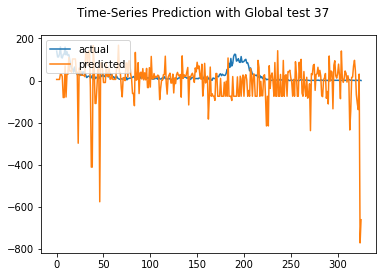

Test MAE: 94.604
Test RMSE: 123.416
Test sMAPE: 145.844
Test R Squared: -13.019
{'mae': 94.60366244056473, 'rmse': 123.41625987881125, 'smape': 145.84361567032582, 'r2': -13.01945652637977}


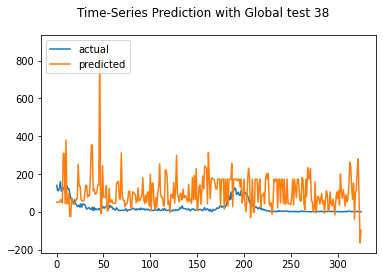

Test MAE: 93.998
Test RMSE: 129.631
Test sMAPE: 149.689
Test R Squared: -14.467
{'mae': 93.99791214436841, 'rmse': 129.6312299943672, 'smape': 149.6888718268547, 'r2': -14.466986264145946}


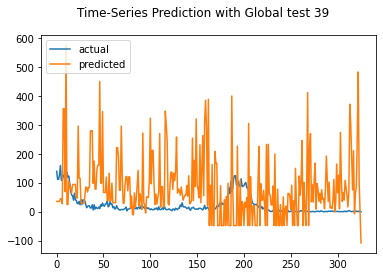

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 52.439
Test RMSE: 64.044
Test sMAPE: 135.349
Test R Squared: -2.775
{'mae': 52.43939640203868, 'rmse': 64.0440072306878, 'smape': 135.3491978918183, 'r2': -2.775229969538301}


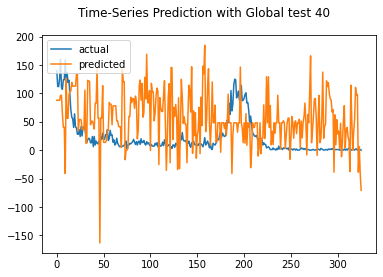

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 50.913
Test RMSE: 65.988
Test sMAPE: 143.142
Test R Squared: -3.008
{'mae': 50.913211846827, 'rmse': 65.98753090650982, 'smape': 143.14213760772793, 'r2': -3.007838132574025}


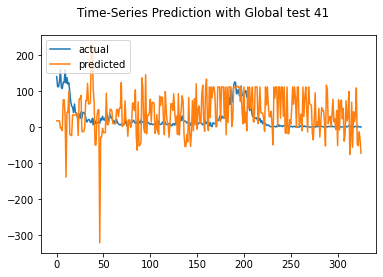

Test MAE: 60.181
Test RMSE: 73.971
Test sMAPE: 133.617
Test R Squared: -4.036
{'mae': 60.180821427721185, 'rmse': 73.97077025528634, 'smape': 133.61730012908293, 'r2': -4.036243249245357}


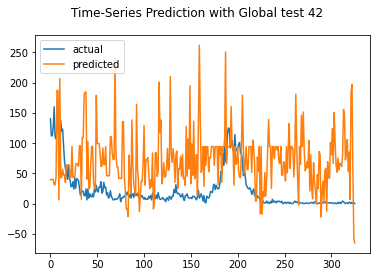

Test MAE: 115.701
Test RMSE: 156.141
Test sMAPE: 158.324
Test R Squared: -21.440
{'mae': 115.70114419613878, 'rmse': 156.14095695543884, 'smape': 158.3242472739799, 'r2': -21.439857241580725}


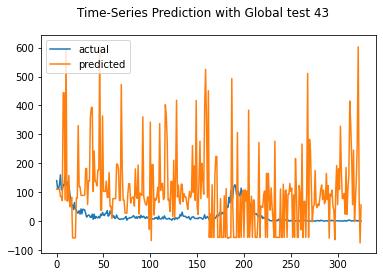

Test MAE: 41.275
Test RMSE: 50.530
Test sMAPE: 137.123
Test R Squared: -1.350
{'mae': 41.27516612629949, 'rmse': 50.5303683545566, 'smape': 137.12308269112822, 'r2': -1.3501270676571329}


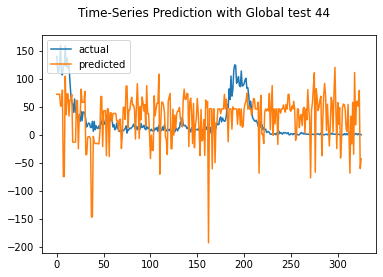

Test MAE: 140.464
Test RMSE: 172.930
Test sMAPE: 154.477
Test R Squared: -26.525
{'mae': 140.4643874848547, 'rmse': 172.9297597937839, 'smape': 154.47732941370816, 'r2': -26.524909053024302}


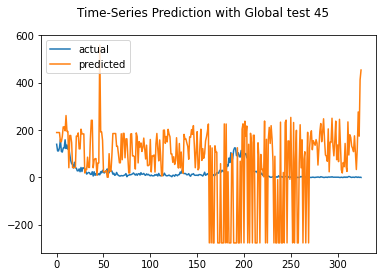

Test MAE: 78.948
Test RMSE: 92.484
Test sMAPE: 152.591
Test R Squared: -6.873
{'mae': 78.94808804440352, 'rmse': 92.48389691269088, 'smape': 152.59081862006445, 'r2': -6.872608560304721}


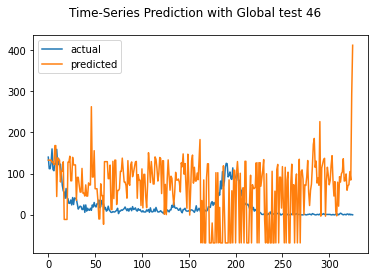

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 47.825
Test RMSE: 65.526
Test sMAPE: 132.430
Test R Squared: -2.952
{'mae': 47.82507342301263, 'rmse': 65.52622158006407, 'smape': 132.4304063927808, 'r2': -2.9519975653879666}


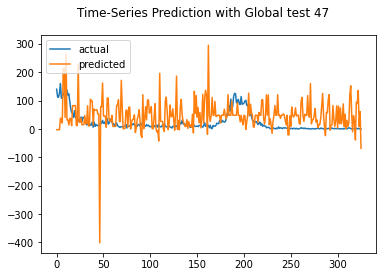

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 64.615
Test RMSE: 80.695
Test sMAPE: 149.007
Test R Squared: -4.993
{'mae': 64.61469309900436, 'rmse': 80.6946968337805, 'smape': 149.0074485029438, 'r2': -4.993443351281438}


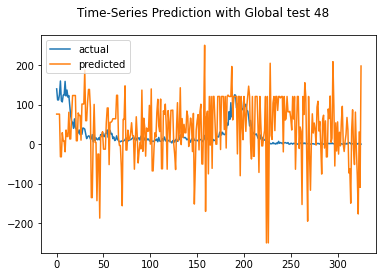

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 48.901
Test RMSE: 58.184
Test sMAPE: 127.974
Test R Squared: -2.116
{'mae': 48.90095041646548, 'rmse': 58.18421128358283, 'smape': 127.97397168375903, 'r2': -2.115994765525538}


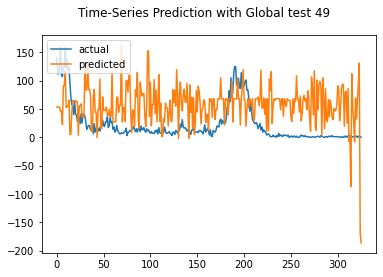

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 56.787
Test RMSE: 69.466
Test sMAPE: 133.090
Test R Squared: -3.442
{'mae': 56.786569504650096, 'rmse': 69.46634706590646, 'smape': 133.09046893747555, 'r2': -3.441558021741705}


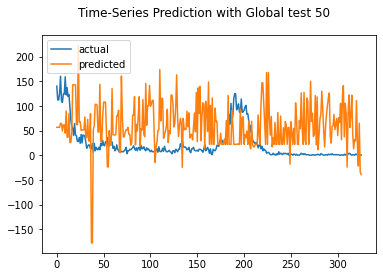

Test MAE: 61.149
Test RMSE: 78.657
Test sMAPE: 143.877
Test R Squared: -4.695
{'mae': 61.14896004605878, 'rmse': 78.65676343820584, 'smape': 143.87747491834034, 'r2': -4.694538853614105}


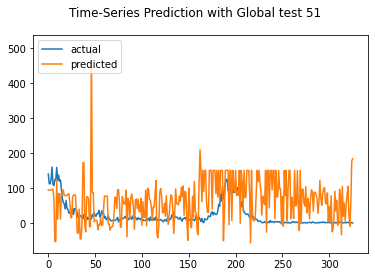

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 54.706
Test RMSE: 65.913
Test sMAPE: 135.189
Test R Squared: -2.999
{'mae': 54.706089257279785, 'rmse': 65.91302333116795, 'smape': 135.18913333684844, 'r2': -2.9987926140516126}


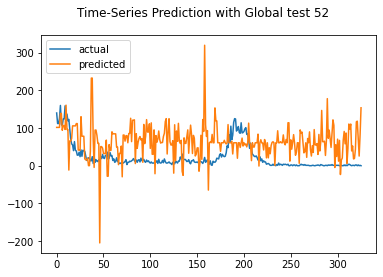

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 53.104
Test RMSE: 70.779
Test sMAPE: 131.261
Test R Squared: -3.611
{'mae': 53.10382792115943, 'rmse': 70.77932603654904, 'smape': 131.26122783598973, 'r2': -3.611043954425601}


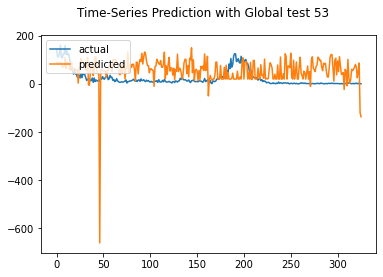

Test MAE: 136.120
Test RMSE: 153.918
Test sMAPE: 161.467
Test R Squared: -20.805
{'mae': 136.1202444298867, 'rmse': 153.91784825966224, 'smape': 161.46695817781512, 'r2': -20.805416326529624}


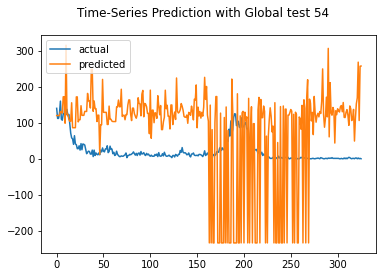

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 40.515
Test RMSE: 50.977
Test sMAPE: 126.567
Test R Squared: -1.392
{'mae': 40.51464638095692, 'rmse': 50.97705518042272, 'smape': 126.5665732728749, 'r2': -1.3918608133063497}


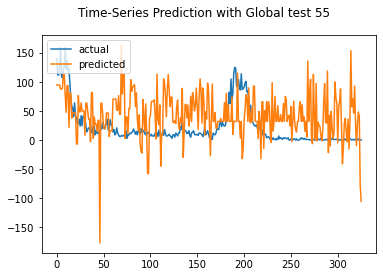

Test MAE: 99.941
Test RMSE: 117.324
Test sMAPE: 156.722
Test R Squared: -11.670
{'mae': 99.9408792242682, 'rmse': 117.3244854027837, 'smape': 156.7220168066421, 'r2': -11.66962417140262}


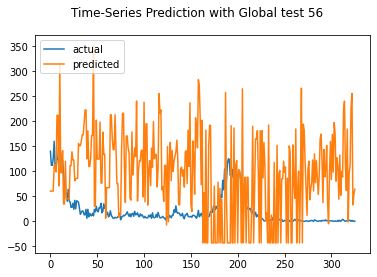

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 40.292
Test RMSE: 54.625
Test sMAPE: 140.106
Test R Squared: -1.746
{'mae': 40.29249589995373, 'rmse': 54.62525453093418, 'smape': 140.1055071168333, 'r2': -1.7464605387494512}


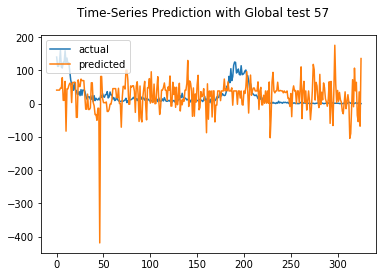

Test MAE: 110.884
Test RMSE: 133.870
Test sMAPE: 160.734
Test R Squared: -15.495
{'mae': 110.88420301127287, 'rmse': 133.86991603695876, 'smape': 160.73443264934556, 'r2': -15.495002975090184}


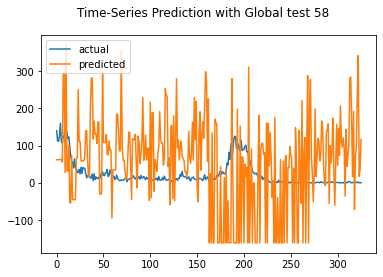

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 45.836
Test RMSE: 64.641
Test sMAPE: 129.076
Test R Squared: -2.846
{'mae': 45.83573440028115, 'rmse': 64.6408387609635, 'smape': 129.07633325874696, 'r2': -2.845921206644939}


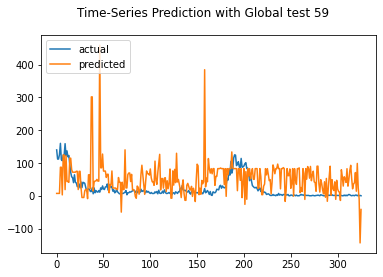

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 52.909
Test RMSE: 70.142
Test sMAPE: 156.790
Test R Squared: -3.528
{'mae': 52.9089449182427, 'rmse': 70.14238285508415, 'smape': 156.78953520569232, 'r2': -3.5284277934831803}


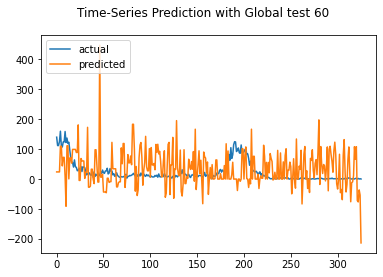

Test MAE: 49.468
Test RMSE: 58.516
Test sMAPE: 134.531
Test R Squared: -2.152
{'mae': 49.46767979421499, 'rmse': 58.51648418975172, 'smape': 134.53083520043475, 'r2': -2.1516854428889807}


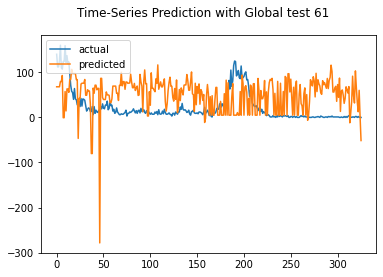

Test MAE: 89.117
Test RMSE: 153.071
Test sMAPE: 134.918
Test R Squared: -20.566
{'mae': 89.1172193735838, 'rmse': 153.07088584496478, 'smape': 134.91843592794223, 'r2': -20.5660996337757}


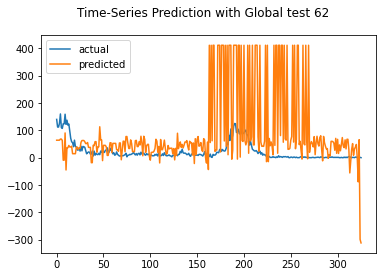

Test MAE: 34.120
Test RMSE: 45.306
Test sMAPE: 133.771
Test R Squared: -0.889
{'mae': 34.12020635257469, 'rmse': 45.30560414178314, 'smape': 133.77124017244518, 'r2': -0.88925364262746}


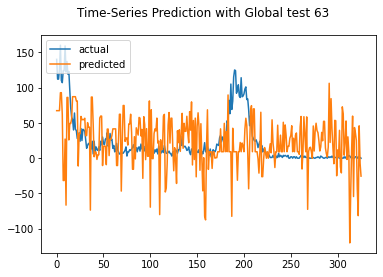

Test MAE: 54.067
Test RMSE: 64.422
Test sMAPE: 139.755
Test R Squared: -2.820
{'mae': 54.06701139072699, 'rmse': 64.42219823558203, 'smape': 139.75473690445045, 'r2': -2.819948395431581}


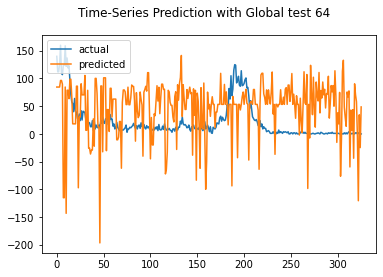

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 41.170
Test RMSE: 48.721
Test sMAPE: 131.432
Test R Squared: -1.185
{'mae': 41.170312172064754, 'rmse': 48.72094984395866, 'smape': 131.4321397075121, 'r2': -1.1848313019484231}


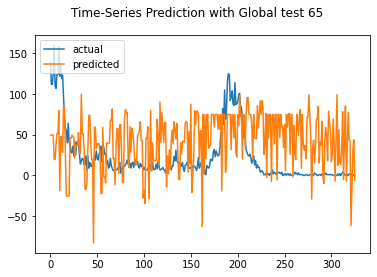

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 39.603
Test RMSE: 49.145
Test sMAPE: 136.798
Test R Squared: -1.223
{'mae': 39.6025558713755, 'rmse': 49.14484198153473, 'smape': 136.79792442152015, 'r2': -1.2230145344356083}


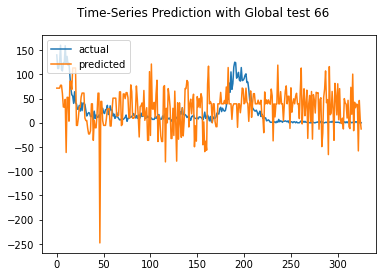

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 50.194
Test RMSE: 61.996
Test sMAPE: 134.528
Test R Squared: -2.538
{'mae': 50.19411953991176, 'rmse': 61.99644389352115, 'smape': 134.52843847389966, 'r2': -2.537691633559981}


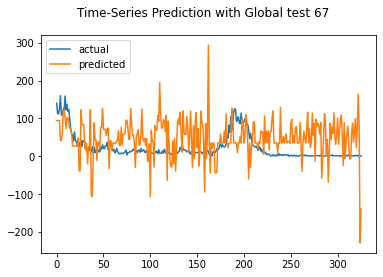

Test MAE: 61.901
Test RMSE: 75.914
Test sMAPE: 145.241
Test R Squared: -4.304
{'mae': 61.90126069173491, 'rmse': 75.91366968236257, 'smape': 145.24100249775393, 'r2': -4.304279346578705}


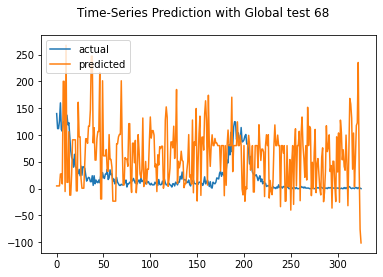

Test MAE: 124.073
Test RMSE: 157.125
Test sMAPE: 154.443
Test R Squared: -21.724
{'mae': 124.07297497731777, 'rmse': 157.12483820840808, 'smape': 154.442939132377, 'r2': -21.72354596925085}


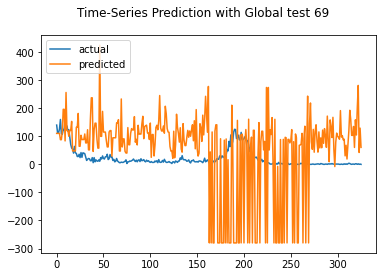

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 47.043
Test RMSE: 56.202
Test sMAPE: 130.924
Test R Squared: -1.907
{'mae': 47.04323039830096, 'rmse': 56.20237510455225, 'smape': 130.92351344343837, 'r2': -1.9073395387511654}


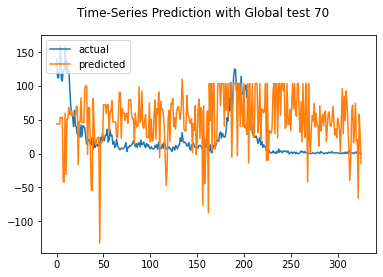

Test MAE: 118.053
Test RMSE: 169.709
Test sMAPE: 170.083
Test R Squared: -25.509
{'mae': 118.05339236456923, 'rmse': 169.70868940713444, 'smape': 170.08267483206274, 'r2': -25.509075094000337}


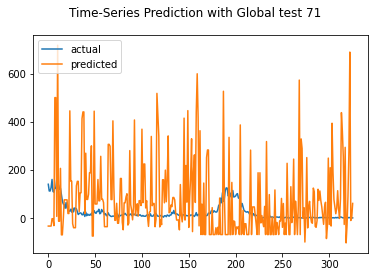

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 55.632
Test RMSE: 83.833
Test sMAPE: 159.852
Test R Squared: -5.469
{'mae': 55.631528269111016, 'rmse': 83.83349520905125, 'smape': 159.8516110638186, 'r2': -5.468767808268688}


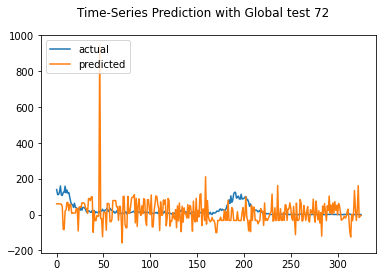

Test MAE: 76.305
Test RMSE: 84.537
Test sMAPE: 141.685
Test R Squared: -5.578
{'mae': 76.30512873526732, 'rmse': 84.53729656161094, 'smape': 141.68453290977035, 'r2': -5.577837294529264}


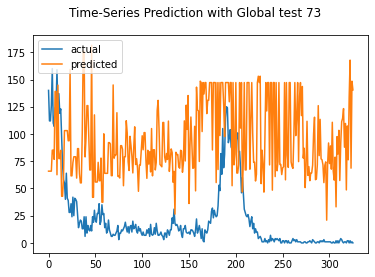

Test MAE: 92.928
Test RMSE: 125.841
Test sMAPE: 148.665
Test R Squared: -13.576
{'mae': 92.92791441978852, 'rmse': 125.84096567094906, 'smape': 148.6650649036627, 'r2': -13.575736240454507}


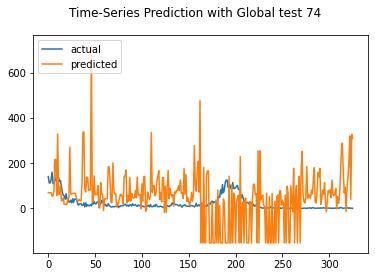

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 63.838
Test RMSE: 78.720
Test sMAPE: 144.926
Test R Squared: -4.704
{'mae': 63.838404619894874, 'rmse': 78.71992564463137, 'smape': 144.9263338146928, 'r2': -4.703688074510154}


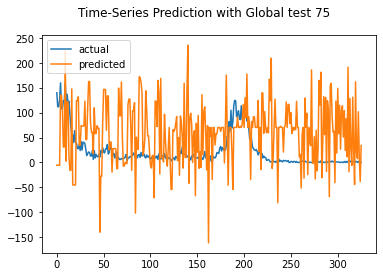

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 47.590
Test RMSE: 58.553
Test sMAPE: 131.121
Test R Squared: -2.156
{'mae': 47.59032791231308, 'rmse': 58.553292073767, 'smape': 131.12096952887353, 'r2': -2.1556516195658317}


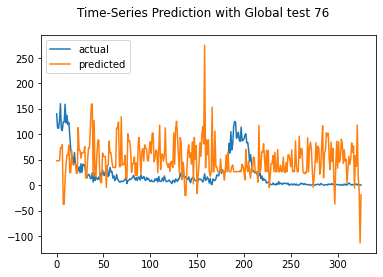

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 46.932
Test RMSE: 57.599
Test sMAPE: 128.951
Test R Squared: -2.054
{'mae': 46.93203704635059, 'rmse': 57.59892880785528, 'smape': 128.95094558765524, 'r2': -2.053621675392045}


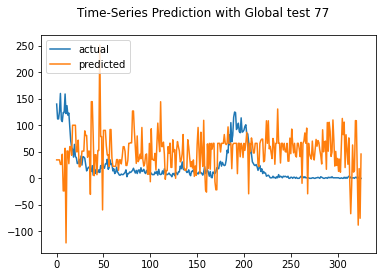

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 64.515
Test RMSE: 76.506
Test sMAPE: 141.125
Test R Squared: -4.387
{'mae': 64.51509331559842, 'rmse': 76.50627395806578, 'smape': 141.1245879022023, 'r2': -4.387416087119444}


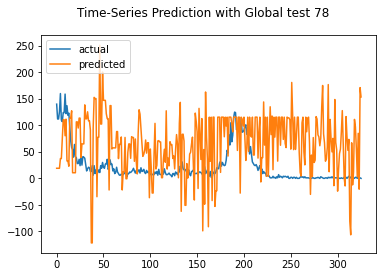

Test MAE: 90.744
Test RMSE: 112.356
Test sMAPE: 149.860
Test R Squared: -10.619
{'mae': 90.74408542744222, 'rmse': 112.35564008003566, 'smape': 149.85966698132506, 'r2': -10.619198539567469}


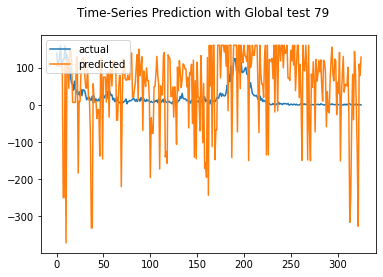

Test MAE: 54.318
Test RMSE: 62.970
Test sMAPE: 132.062
Test R Squared: -2.650
{'mae': 54.318008960573216, 'rmse': 62.969805638926445, 'smape': 132.06241474909476, 'r2': -2.649649193861194}


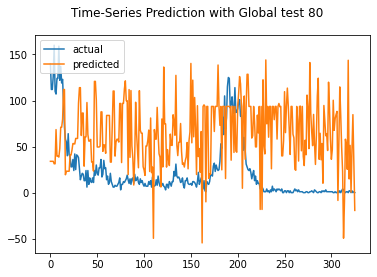

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 51.683
Test RMSE: 71.322
Test sMAPE: 141.381
Test R Squared: -3.682
{'mae': 51.68333348613575, 'rmse': 71.32189744996599, 'smape': 141.38114581216803, 'r2': -3.682008453526935}


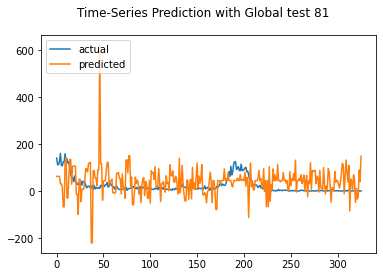

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 68.013
Test RMSE: 85.358
Test sMAPE: 139.573
Test R Squared: -5.706
{'mae': 68.01344047038833, 'rmse': 85.35791123859387, 'smape': 139.57264939436666, 'r2': -5.706160980384982}


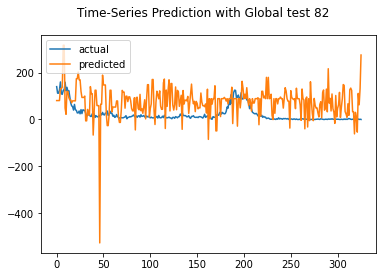

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 46.665
Test RMSE: 60.513
Test sMAPE: 132.995
Test R Squared: -2.370
{'mae': 46.66474118289406, 'rmse': 60.513111992017535, 'smape': 132.9945709384713, 'r2': -2.370430622089494}


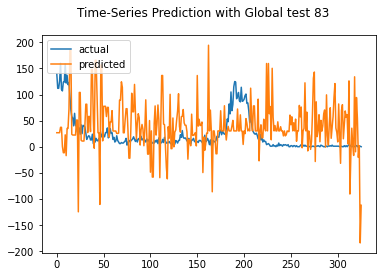

Test MAE: 57.068
Test RMSE: 61.460
Test sMAPE: 136.432
Test R Squared: -2.477
{'mae': 57.06771878084522, 'rmse': 61.46009381093183, 'smape': 136.43156810874947, 'r2': -2.4767451207965654}


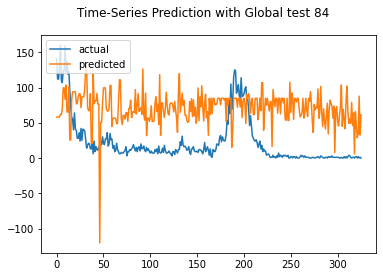

Test MAE: 60.525
Test RMSE: 75.822
Test sMAPE: 143.292
Test R Squared: -4.291
{'mae': 60.52458773032288, 'rmse': 75.82164484850483, 'smape': 143.2918612464659, 'r2': -4.291427127275294}


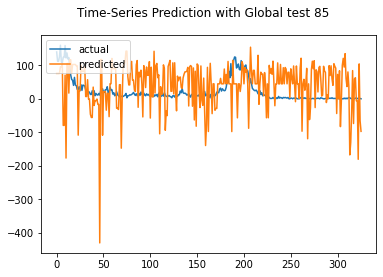

Test MAE: 75.379
Test RMSE: 85.003
Test sMAPE: 153.647
Test R Squared: -5.650
{'mae': 75.37883319573169, 'rmse': 85.00252118667035, 'smape': 153.64679436254224, 'r2': -5.650434653665863}


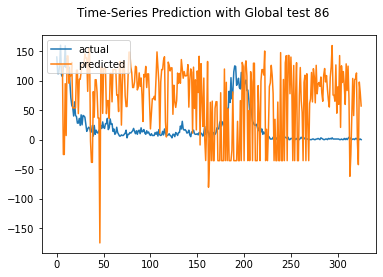

Test MAE: 77.708
Test RMSE: 99.517
Test sMAPE: 155.023
Test R Squared: -8.115
{'mae': 77.70822981109649, 'rmse': 99.5168186956548, 'smape': 155.0233556029994, 'r2': -8.115476687853894}


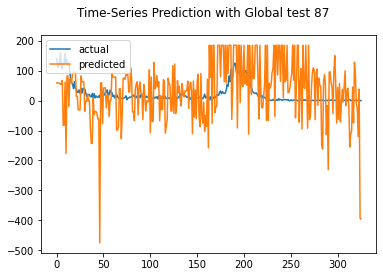

Test MAE: 93.088
Test RMSE: 139.301
Test sMAPE: 146.076
Test R Squared: -16.861
{'mae': 93.0875318616263, 'rmse': 139.30082321704626, 'smape': 146.07551390693658, 'r2': -16.860506968181586}


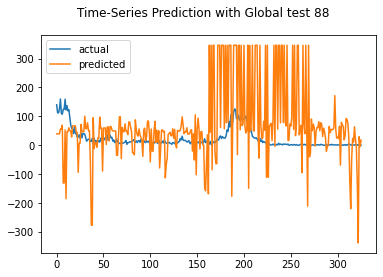

Test MAE: 92.114
Test RMSE: 122.281
Test sMAPE: 147.126
Test R Squared: -12.763
{'mae': 92.11387330951867, 'rmse': 122.28133755572676, 'smape': 147.1258758074612, 'r2': -12.762799319128382}


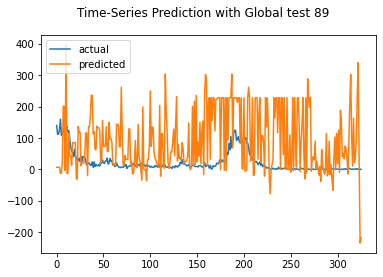

Test MAE: 65.586
Test RMSE: 74.606
Test sMAPE: 139.592
Test R Squared: -4.123
{'mae': 65.58573048941197, 'rmse': 74.60606187893437, 'smape': 139.59236638128417, 'r2': -4.123121414317569}


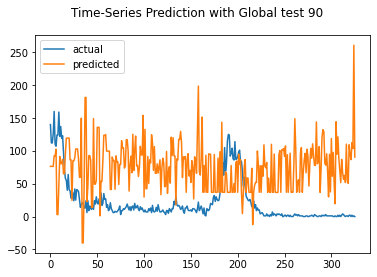

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 50.659
Test RMSE: 69.338
Test sMAPE: 133.293
Test R Squared: -3.425
{'mae': 50.65854750966733, 'rmse': 69.3378226551918, 'smape': 133.29257007221653, 'r2': -3.425137968908536}


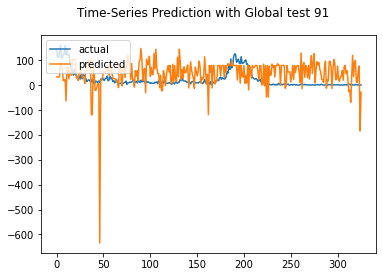

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 49.432
Test RMSE: 60.265
Test sMAPE: 130.446
Test R Squared: -2.343
{'mae': 49.432014863183895, 'rmse': 60.26527443709662, 'smape': 130.44601792766164, 'r2': -2.3428792802474256}


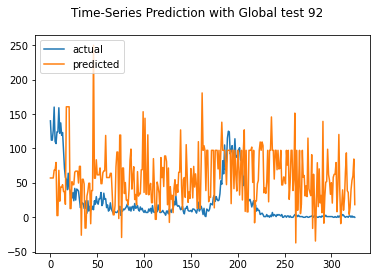

Test MAE: 69.032
Test RMSE: 80.397
Test sMAPE: 151.277
Test R Squared: -4.949
{'mae': 69.03162175453514, 'rmse': 80.39738329690165, 'smape': 151.27724156695535, 'r2': -4.94935993034382}


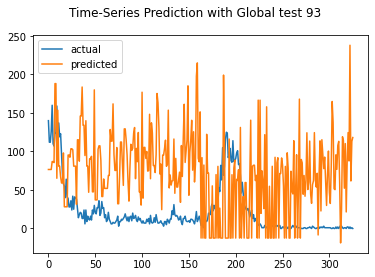

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 43.461
Test RMSE: 53.472
Test sMAPE: 134.713
Test R Squared: -1.632
{'mae': 43.4610099136098, 'rmse': 53.47219491286683, 'smape': 134.7134242375613, 'r2': -1.6317367117653894}


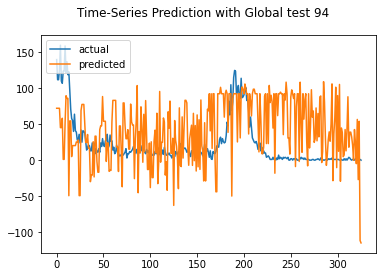

Test MAE: 71.597
Test RMSE: 90.279
Test sMAPE: 137.091
Test R Squared: -6.502
{'mae': 71.59689129715316, 'rmse': 90.27923925718562, 'smape': 137.0910012665896, 'r2': -6.501743278815774}


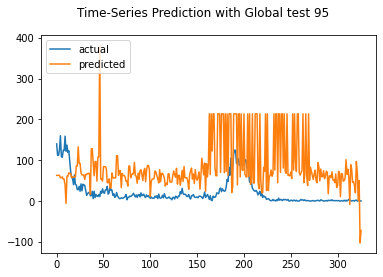

Test MAE: 58.048
Test RMSE: 79.033
Test sMAPE: 135.760
Test R Squared: -4.749
{'mae': 58.04798432782384, 'rmse': 79.03332145287396, 'smape': 135.76017089137434, 'r2': -4.749192947531983}


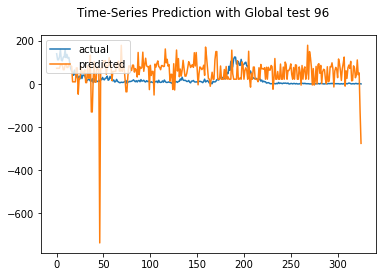

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 64.584
Test RMSE: 80.332
Test sMAPE: 157.788
Test R Squared: -4.940
{'mae': 64.58369295052223, 'rmse': 80.33153216555779, 'smape': 157.78770455084734, 'r2': -4.939618030256211}


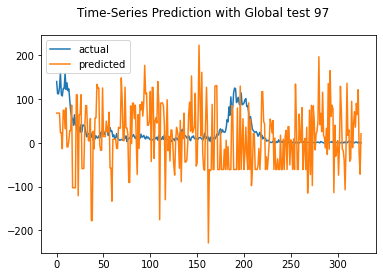

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 52.911
Test RMSE: 63.854
Test sMAPE: 136.208
Test R Squared: -2.753
{'mae': 52.9108875119613, 'rmse': 63.85409586413854, 'smape': 136.20774997925082, 'r2': -2.752873589768622}


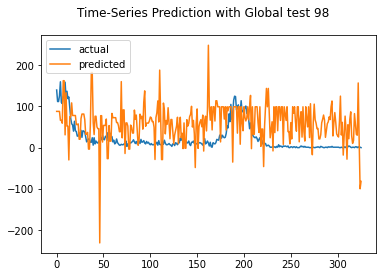

Test MAE: 99.516
Test RMSE: 127.218
Test sMAPE: 157.570
Test R Squared: -13.896
{'mae': 99.51573191738568, 'rmse': 127.21777504124876, 'smape': 157.57037590030367, 'r2': -13.896423400647086}


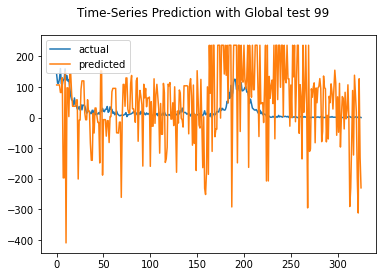

rmse : average=83.789, std=30.890
mae : average=65.848, std=23.408
smape : average=142.273, std=10.691
r2 : average=-6.340, std=5.898


([83.78850950461637, 30.889713595661366],
 [65.84810429505592, 23.408266113644828],
 [142.2731484738878, 10.690629952774948],
 [-6.340069242347521, 5.898387543584973])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
